<!-- Centered layout with a university logo -->
<div align="center">

  <!-- University Logo -->
  <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <!-- Assignment Title -->
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">Deep Reinforcement Learning</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Assignment 06 - Multi-Armed and Contextual Bandits</h2>

  <!-- Department and University -->
  <h3 style="color:#696880; font-size: 24px; margin-top: 20px;">Computer Engineering Department</h3>
  <h3 style="color:#696880; font-size: 22px; margin-top: -5px;">Sharif University of Technology</h3>

  <!-- Semester -->
  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">Spring 2025</h3>

  <!-- Authors -->
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Payam Taebi</h3>
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">400104867</h3>

  <!-- Horizontal Line for Separation -->
  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


## Setup & Overview  
In this notebook, we simulate bandit problems using *MAB* (Multi-Armed Bandit) and *CtxBnd* (Contextual Bandit) frameworks.  
We compare several agents:
- **Oracle** (with privileged info)
- **RndAg** (Random Agent)
- **ExpFstAg** (Explore-First Agent)
- **UCB_Ag** (UCB Agent)
- **EpsGdAg** (Epsilon-Greedy Agent)
- **LinUCB_Ag** (LinUCB for contextual bandits)


Follow the instructions carefully and complete the sections marked with **TODO**.

## Setup and Environment

In the upcoming cells, we import necessary libraries, set up utility functions for reproducibility and plotting, and define the basic components of our bandit experiments.


In [ ]:
# %% [code]
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dataclasses import dataclass
from copy import deepcopy
from tqdm.notebook import tqdm

plt.rcParams['figure.dpi'] = 100

In [ ]:
# %% [code]
def plot_logs(df, x_key, y_key, legend_key, **kwargs):
    num = len(df[legend_key].unique())
    pal = sns.color_palette("hls", num)
    if 'palette' not in kwargs:
        kwargs['palette'] = pal
    ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
    return ax

def set_seed(s):
    np.random.seed(s)
    random.seed(s)

set_seed(0)

## MAB Overview  
We consider a bandit with 10 arms. Two formulations:  
- **Stochastic:** Each arm gives a reward of 1 with probability *p*.  
- **Deterministic:** Each arm always returns a fixed reward.  
  
We'll work with the stochastic case. The reward probabilities will be set randomly.

In [ ]:
# %% [code]
nArms = 10
p_arr = [np.random.random() for _ in range(nArms)]
print("Probabilities:", p_arr)

Probabilities: [0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


**Q:** How might the performance of different agents change if the distribution of probabilities were not uniform?  

**A:**

When the distribution of reward probabilities is non-uniform, some arms will have significantly higher or lower rewards compared to others. This variation affects how each agent performs:

- **Differentiation of Arms:**  
  Non-uniform distributions create a clear distinction between high-reward and low-reward arms. This makes it crucial for an agent to efficiently identify and exploit the best arms while avoiding poor ones.

- **Exploration vs. Exploitation Balance:**  
  Agents must balance exploring all arms and exploiting the seemingly best arm. In a skewed distribution, effective exploration is key to accurately discovering high-reward arms, which might be missed if an agent relies too heavily on early estimates.

- **Agent-Specific Considerations:**
  - **Oracle:**  
    With full knowledge of the environment, the Oracle always picks the best arm, so its performance remains optimal regardless of the probability distribution.
  
  - **Random Agent (RndAg):**  
    Since it selects arms at random, its performance would likely degrade in a non-uniform setting because it may frequently choose low-reward arms.
  
  - **Explore-First Agent (ExpFstAg):**  
    This agent samples all arms during an initial exploration phase before committing to the best one. If the exploration period is too short, it might not sample the high-reward arms sufficiently, especially if those arms are rare or require more trials to reveal their superiority.
  
  - **Upper Confidence Bound Agent (UCB_Ag):**  
    UCB_Ag uses statistical confidence to balance exploration and exploitation. It allocates more exploration to arms with uncertain yet potentially high rewards, making it more robust in non-uniform settings.
  
  - **Epsilon-Greedy Agent (EpsGdAg):**  
    This agent randomly explores with a fixed probability (epsilon) and exploits the best-known arm otherwise. Its performance heavily depends on the value of epsilon: too high, and it wastes opportunities on low-reward arms; too low, and it might


In [ ]:
# %% [code]
@dataclass
class MAB_Env:
    p_arr: np.ndarray

    def step(self, act):
        return 1 if np.random.random() < self.p_arr[act] else 0

**Q:** Why does the MAB environment use a simple binary reward mechanism (1 or 0)?

**A:**

The MAB environment uses a simple binary reward mechanism (1 or 0) for several reasons:

- **Simplicity and Clarity:**  
  Binary rewards (often modeled as Bernoulli outcomes) simplify the reward structure, making it easier to analyze and understand the performance of different agents.

- **Mathematical Tractability:**  
  The binary setup is mathematically straightforward, allowing for clear derivations of probabilities, expected rewards, and regret bounds. This simplicity is especially useful in theoretical analyses and proofs.

- **Standard Benchmark:**  
  Many multi-armed bandit studies use binary rewards as a baseline. This standardization facilitates comparisons between different algorithms and research studies.

- **Focus on Decision-Making:**  
  With binary rewards, the challenge is centered on correctly identifying which arm has a higher chance of yielding a reward of 1, emphasizing the exploration-exploitation trade-off without the added complexity of varying reward magnitudes.


In [ ]:
# %% [code]
@dataclass
class MAB_Eng:
    p_arr: np.ndarray
    max_steps: int
    agent: any

    def __post_init__(self):
        self.env = MAB_Env(p_arr=self.p_arr)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_acts = []
            self.agent.reset()
            for t in range(self.max_steps):
                act = self.agent.get_action()
                rew = self.env.step(act)
                self.agent.update_Q(act, rew)
                run_acts.append(act)
                run_rewards.append(rew)
            logs.append(pd.DataFrame({
                'reward': run_rewards,
                'action': run_acts,
                'step': np.arange(len(run_rewards))
            }))
        return pd.concat(logs, ignore_index=True)

In [ ]:
# %% [code]
def mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500):
    all_logs = []
    for idx, agent in enumerate(tqdm(agents, desc="Alg Sweeps")):
        engine = MAB_Eng(p_arr=p_arr, max_steps=max_steps, agent=agent)
        log_df = engine.run(n_runs)
        log_df['Alg'] = labels[idx]
        all_logs.append(log_df)
    return pd.concat(all_logs, ignore_index=True)

## Oracle Agent  
The **Oracle** has full knowledge of *p_arr*.  
**Question:** What is the maximum expected per-step reward?

**A:**

The maximum expected per-step reward is achieved by always selecting the arm with the highest probability of giving a reward. Since each arm returns a reward of 1 with probability given by its corresponding element in *p_arr*, the expected reward when selecting an arm is simply its probability of reward.

Thus, the maximum expected per-step reward is:
  
**max(p_arr)**

This means that if the Oracle agent always chooses the arm with the highest probability in *p_arr*, it will obtain an expected reward equal to the maximum value in *p_arr* at each step.


In [ ]:
# Compute oracleReward using privileged info: maximum probability among all arms
oracleReward = np.max(p_arr)
print(f'Max possible reward (Simple): {oracleReward}')


Max possible reward (Simple): 0.9636627605010293


**Q:** What insight does the oracle reward give us about the best possible performance?

**A:**

The oracle reward represents the theoretical upper bound of performance in the multi-armed bandit problem. It is computed by taking the maximum probability from the array *p_arr*, which signifies the best arm available. This value tells us the maximum expected per-step reward that any agent could achieve if it always selected the optimal arm. In practical terms, it serves as a benchmark:

- **Benchmarking Tool:**  
  The oracle reward provides a clear reference point against which the performance of other, more realistic agents can be measured. By comparing their average rewards to the oracle's, we can assess how effectively these agents learn and exploit the best arm.

- **Performance Upper Bound:**  
  It defines the best-case scenario under ideal conditions where an agent has perfect knowledge of the environment. No learning algorithm can exceed this performance, which makes it a crucial goalpost in evaluating exploration and exploitation strategies.

- **Insight into Regret:**  
  The difference between the oracle reward and the actual reward obtained by a learning agent is often interpreted as the agent's regret. This gap quantifies the loss incurred due to the exploration process and the uncertainty in reward estimation.

- **Guidance for Algorithm Design:**  
  Knowing the oracle reward helps in understanding how close an algorithm is to optimal performance and can guide the development and tuning of algorithms to minimize the regret, hence moving performance closer to this theoretical limit.



-------------------

**Q:** Why is the oracle considered “cheating” in a practical sense?  

**A:**

In practical applications, the oracle is considered "cheating" because it assumes access to information that is normally unavailable to a learning agent:

- **Access to Privileged Information:**  
  The oracle has full knowledge of the true reward probabilities for every arm in the bandit problem. In reality, these probabilities are unknown and must be learned through interactions with the environment.

- **Bypassing the Exploration Process:**  
  One of the core challenges in multi-armed bandit problems is balancing exploration (trying out different arms to learn about their rewards) and exploitation (selecting the arm that currently appears to be the best). The oracle circumvents this challenge entirely by always choosing the best arm, thereby ignoring the fundamental trade-off inherent in the problem.

- **Unrealistic in Real-World Scenarios:**  
  In real-world applications, such complete knowledge of the environment is not available. Algorithms must operate under uncertainty and learn from experience, which involves making decisions based on limited or noisy data. The oracle's performance, while ideal, is unattainable because it does not involve any learning or adaptation process.

- **Benchmark vs. Feasible Strategy:**  
  Although the oracle is useful as a performance benchmark, it does not represent a feasible strategy for practical deployment. It sets a standard that helps to evaluate how much room there is for improvement in actual learning algorithms, rather than offering a method that can be implemented in practice.


## RndAg (Random Agent)  
This agent selects an action at random at every timestep. It does no learning.


In [ ]:
@dataclass
class RndAg:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        pass  # No learning

    def get_action(self):
      self.t += 1
      # Select a random action index from 0 to n_act-1
      sel_act = np.random.randint(self.n_act)
      return sel_act


In [ ]:
# %% [code]
rnd_agent = RndAg(n_act=len(p_arr))
n_runs = 1000
rnd_log = mab_swp([rnd_agent], p_arr, ['Rnd'], n_runs=n_runs)

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


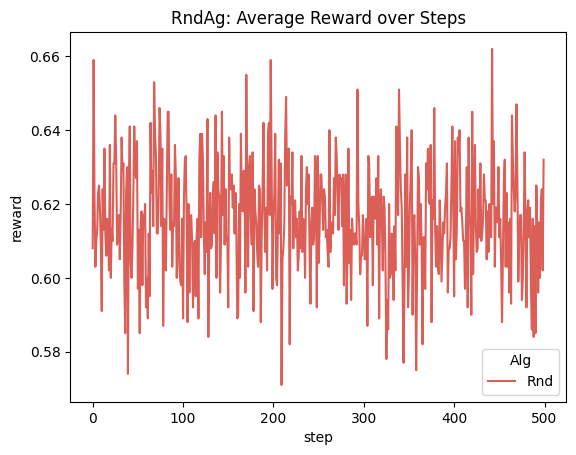

In [ ]:
# %% [code]
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("RndAg: Average Reward over Steps")
plt.show()

**Q:** Why is the reward of the random agent generally lower and highly variable?

**A**

A random agent selects actions without any strategic insight or learning mechanism—it simply picks an arm uniformly at random at every timestep. Because it ignores historical performance or any statistical information about the arms, the agent frequently chooses suboptimal actions. This lack of discrimination means that, on average, it earns a lower reward compared to agents that can identify and exploit the best arms. Additionally, since the selections are purely random, the outcomes can vary widely from one run to another, leading to high variability in the accumulated rewards. The inconsistency in its choices results in both lower average performance and a wide spread of rewards over time.


------------

**Q:** How might you improve a random agent without using any learning mechanism?

**A:**

Even without incorporating a learning mechanism, there are ways to enhance a random agent’s performance by introducing a bias into its random selection process. One approach is to use a two-phase strategy:
  
1. **Initial Exploration Phase:**  
   Conduct a fixed, one-time exploration where the agent samples each arm a predetermined number of times to gather preliminary performance data. This phase would provide a rough estimate of the reward probabilities for each arm.
  
2. **Biased Random Selection:**  
   After the exploration phase, rather than selecting actions uniformly at random, the agent can use a weighted or biased random selection where the probability of choosing an arm is proportional to the reward observed during the initial phase. This adjustment allows the agent to favor arms that appear to offer higher rewards, thereby improving the average reward over time.

This method does not involve continuous learning or updating during the main phase of operation—it simply leverages initial, static information to bias subsequent random choices. In practice, this "biased random" strategy can reduce variance and improve overall performance compared to a purely random selection, without implementing a full learning mechanism.


<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


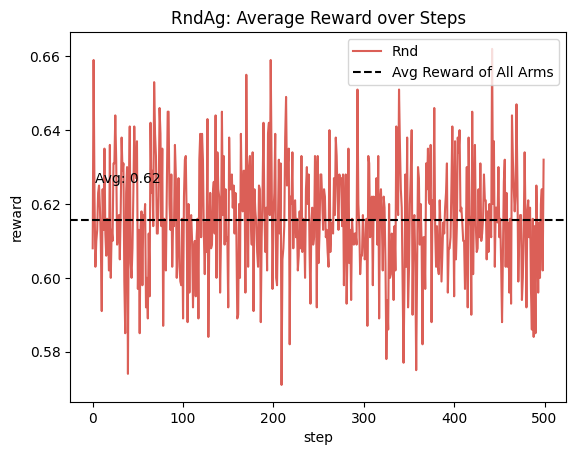

In [ ]:
# Plot RndAg reward curve and average reward of all arms (Simple)
ax = plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)

# Calculate the average reward of all arms (i.e., the mean probability)
avg_reward = np.mean(p_arr)

# Overlay a horizontal line showing the average reward of all arms
ax.axhline(avg_reward, color='black', linestyle='--', label='Avg Reward of All Arms')

# Annotate the average reward value on the plot
# Adjust the x position (here 5% of the x-axis) and a slight vertical offset above the line for clarity.
ax.text(0.05, avg_reward + 0.01, f'Avg: {avg_reward:.2f}', color='black', transform=ax.get_yaxis_transform())

plt.title("RndAg: Average Reward over Steps")
plt.legend()
plt.show()

**Analysis:**  
- The x-axis shows the number of steps; y-axis shows average reward.  
- Regret is the gap between Oracle and agent performance.

## ExpFstAg (Explore-First Agent)  
This agent explores randomly for the first *max_ex* steps, then exploits the best arm thereafter.

In [ ]:
@dataclass
class ExpFstAg:
    n_act: int
    max_ex: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # Update the Q-value using an incremental sample average method.
        self.act_counts[act] += 1
        self.Q[act] += (rew - self.Q[act]) / self.act_counts[act]

    def get_action(self):
        self.t += 1
        # For the first max_ex steps, explore: choose a random action.
        if self.t <= self.max_ex:
            sel_act = np.random.randint(self.n_act)
        # After the exploration phase, exploit: choose the arm with the highest estimated reward.
        else:
            sel_act = int(np.argmax(self.Q))
        return sel_act

### Run ExpFstAg with max_ex = 5  
We will test ExpFstAg (with 5 exploration steps) over 1000 runs and 500 steps.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


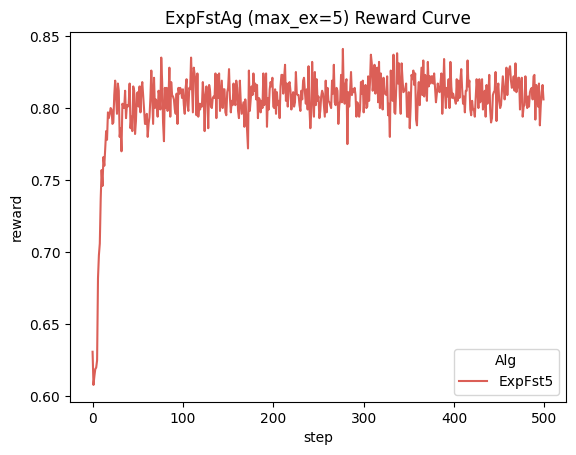

In [ ]:
# %% [code]
max_ex = 5
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)
expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{max_ex}'], n_runs=1000, max_steps=500)
plot_logs(expfst_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"ExpFstAg (max_ex={max_ex}) Reward Curve")
plt.show()

**Analysis:**  
- The ExpFstAg should outperform RndAg by identifying the best arm during exploration.  
- However, with too short exploration, it may miss the best arm.

----------

**Q:** Why might the early exploration phase (e.g., 5 steps) lead to high fluctuations in the reward curve?  

**A:**  
A very short exploration phase, such as 5 steps, provides only a limited number of samples for each arm. This scant sampling can lead to several issues:  

- **High Variance in Estimates:**  
  With just a few samples, the estimates of the arm's true reward probability (i.e., the Q-values) are subject to significant random fluctuations. A small number of trials means that the outcome (either a 0 or 1) heavily influences the estimate, resulting in high variance. Consequently, the agent may form an inaccurate view of which arm is best based solely on noisy early observations.

- **Sensitivity to Outliers:**  
  In the early stages, a few unusually good or bad outcomes can disproportionately impact the average reward estimated for an arm. For instance, if an arm that generally has a low probability of reward happens to yield a couple of successes early on, its Q-value may temporarily spike, misleading the agent into believing it is superior to other arms. Conversely, an arm with a high true reward probability might initially perform poorly, causing its potential to be underestimated.

- **Delayed Convergence:**  
  With limited exploration, the algorithm has not yet had the chance to stabilize its estimates. The exploitation phase, which kicks in after the exploration period, relies on these initial estimates to make a decision. If these estimates are inaccurate, the agent might commit to a suboptimal arm, leading to erratic performance and fluctuations in the reward curve over time.

- **Limited Statistical Significance:**  
  Statistically, 5 samples per arm (or even 5 samples overall if the exploration isn’t evenly distributed) do not provide sufficient evidence to confidently distinguish between the reward probabilities of the arms. This limited data makes the decision rule based on these initial averages highly unreliable, thereby increasing the likelihood of selecting an arm that does not truly maximize the expected reward.

----------

**Q:** What are the trade-offs of using a fixed exploration phase?  

**A:**  
Employing a fixed exploration phase, where the agent explores randomly for a predetermined number of steps before switching to pure exploitation, involves several trade-offs that impact overall performance:

- **Simplicity and Implementation:**  
  A fixed exploration phase is conceptually simple and easy to implement. It divides the algorithm into two clear stages: exploration and exploitation. This separation makes the logic of the agent straightforward, reducing computational complexity and simplifying debugging and analysis.

- **Guaranteed Initial Sampling:**  
  By forcing the agent to explore for a fixed number of steps, every arm gets sampled at least a minimal number of times. This ensures that no arm is completely ignored at the outset, providing a basic dataset from which to form initial estimates of the arms’ reward probabilities.

- **Risk of Insufficient Exploration:**  
  The main drawback is that if the fixed exploration period is too short, it may not gather enough data to accurately reflect the true reward distributions of each arm. Poor estimates during this phase can lead to the selection of a suboptimal arm during the exploitation phase, thereby increasing regret. In particular, if the best arm is not sufficiently sampled, its high reward probability may go undetected, causing the agent to settle on an inferior option.

- **Inflexibility to Environment Variability:**  
  A fixed exploration period does not adapt to the variability or complexity of the environment. In some situations, a longer exploration period might be necessary if the reward distributions are very similar or if the noise in the reward signal is high. Conversely, in a clearly differentiated environment, a shorter exploration phase might be sufficient. The fixed strategy lacks this flexibility and might either over-explore or under-explore depending on the specific scenario.

- **Delayed Exploitation Benefit:**  
  In cases where the best arm could be identified quickly with a few samples, a fixed exploration period forces the agent to continue exploring even after sufficient information has been gathered. This delay in switching to exploitation can result in lost opportunities for higher rewards, thereby reducing the overall efficiency of the algorithm.

- **Trade-off Between Exploration and Exploitation:**  
  The fixed exploration phase embodies a classic trade-off: if it’s too short, the risk of inaccurate estimates increases, leading to poor exploitation; if it’s too long, the agent spends too much time gathering information, missing out on the benefits of exploiting a known good arm. Balancing this trade-off is crucial for optimal performance, and a fixed approach might not be the most adaptive solution in dynamic or uncertain environments.


Running ExpFstAg with max_ex=5...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=10...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=50...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=100...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=200...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


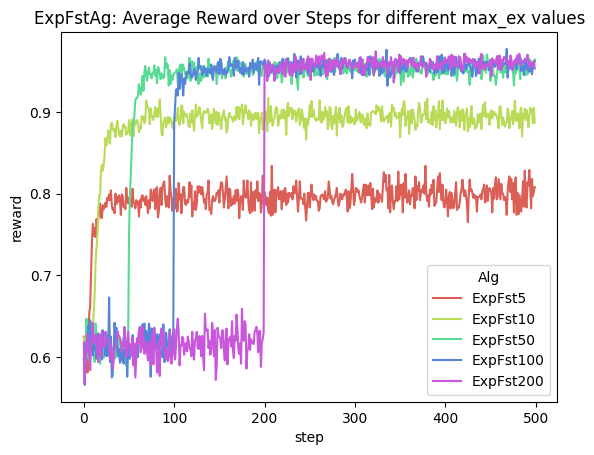

In [ ]:
# Run ExpFstAg for various max_ex values: [5, 10, 50, 100, 200] and plot their reward curves
expfst_logs = []
max_ex_values = [5, 10, 50, 100, 200]

for ex in max_ex_values:
    print(f"Running ExpFstAg with max_ex={ex}...")
    agent = ExpFstAg(n_act=len(p_arr), max_ex=ex)
    log_df = mab_swp([agent], p_arr, [f'ExpFst{ex}'], n_runs=1000, max_steps=500)
    expfst_logs.append(log_df)

# Combine logs from all max_ex values
combined_logs = pd.concat(expfst_logs, ignore_index=True)

# Plot the reward curves for each max_ex value
ax = plot_logs(combined_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("ExpFstAg: Average Reward over Steps for different max_ex values")
plt.show()


**Observations:**  
- Short exploration (e.g., 5 or 10 steps) may not reliably find the best arm.  
- Longer exploration (e.g., 50 or 100 steps) improves performance but may delay exploitation.

**Q:** How does increasing `max_ex` affect the convergence of the agent’s performance?  

**A:**  
Increasing `max_ex`, which represents the number of exploration steps, generally leads to a slower initial convergence as the agent spends more time randomly sampling the arms before committing to exploitation. This extended exploration phase allows the agent to gather more data and improve its estimates of each arm's reward probability, which can result in a more reliable identification of the best arm. In the long run, this improved estimate helps the agent achieve higher and more stable rewards, reducing overall regret. However, the trade-off is that the longer exploration delays the start of exploiting the best arm, which may result in lower cumulative rewards during the early phase of the experiment. Therefore, increasing `max_ex` can improve asymptotic performance while potentially sacrificing early performance.

------------------------------

**Q:** In real-world scenarios, what challenges might arise in selecting the optimal exploration duration?  

**A:**  
In real-world scenarios, selecting the optimal exploration duration is challenging due to several factors:

- **Uncertainty and Variability:**  
  In many applications, the environment may change over time or be inherently noisy, making it difficult to determine how long to explore. An exploration phase that is too short might lead to premature convergence on a suboptimal strategy, while an overly long exploration phase could waste valuable time and resources on sampling inferior options.

- **Dynamic Environments:**  
  Real-world systems are often non-stationary, meaning the underlying reward distributions can shift. This dynamic nature complicates the decision of when to stop exploring, as previously optimal arms might no longer be the best choice. Continuous adaptation may be required, rather than a fixed exploration period.

- **Cost of Exploration:**  
  Exploration can be expensive, either in terms of resources, time, or potential loss of opportunity. In many practical applications, there is a cost associated with gathering additional data. Balancing the benefits of further exploration against these costs is a critical and non-trivial challenge.

- **Complexity of the Action Space:**  
  In many real-world applications, the number of actions (or arms) can be very large, and the relationships between them might be complex. Determining the right amount of exploration in such high-dimensional or complex settings is significantly more challenging than in simplified, controlled experimental setups.

- **Risk of Over-Exploration or Under-Exploration:**  
  Without a mechanism to adaptively balance exploration and exploitation, a fixed exploration duration might lead to over-exploration (wasting time and resources) or under-exploration (failing to identify the best actions). This delicate balance is crucial for maximizing long-term rewards.

Overall, choosing the optimal exploration duration involves trade-offs and must account for environmental dynamics, resource constraints, and the risk-reward balance, making it one of the key challenges in applying bandit algorithms to real-world problems.


## UCB_Ag (UCB Agent)  
UCB dynamically balances exploration and exploitation by adding an exploration bonus to Q-values.

In [ ]:
@dataclass
class UCB_Ag:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # Update Q-value using an incremental average update
        self.act_counts[act] += 1
        self.Q[act] += (rew - self.Q[act]) / self.act_counts[act]

    def get_action(self):
        self.t += 1
        delta = 1e-5  # to avoid division by zero
        # Compute the exploration bonus using the UCB formula:
        # bonus = sqrt((2 * log(total_steps)) / (number of times arm was selected))
        bonus = np.sqrt((2 * np.log(self.t)) / (self.act_counts + delta))
        Q_explore = self.Q + bonus
        # Select an action among those with the highest Q_explore value (tie-breaking randomly)
        sel_act = int(np.random.choice(np.flatnonzero(Q_explore == Q_explore.max())))
        return sel_act


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


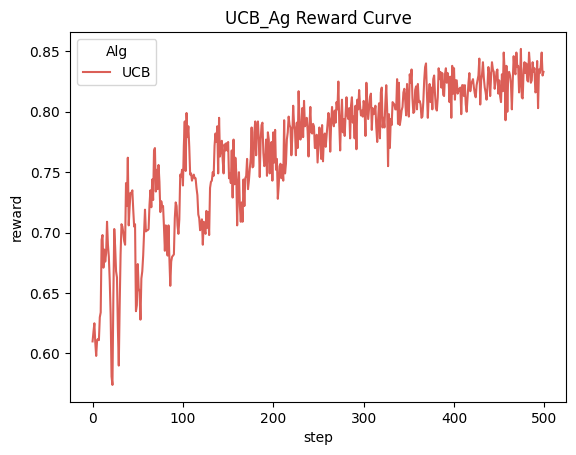

In [ ]:
# %% [code]
ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=500)
plot_logs(ucb_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB_Ag Reward Curve")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?  

**A:**  
An explore-first strategy might outperform UCB in scenarios where the problem horizon is short and rapid decision-making is required. In such cases, a fixed exploration phase (if tuned appropriately) can quickly provide a reliable estimate of the best arm without the overhead of continuously balancing exploration and exploitation. Specific conditions include:

- **Short Time Horizons:**  
  When the total number of steps is limited, an explore-first strategy can quickly switch to exploitation after a brief, dedicated exploration phase. This can be advantageous because UCB’s exploration bonus may lead it to over-explore suboptimal arms in the early stages, reducing short-term performance.

- **Clear Separation in Arm Quality:**  
  If there is a significant gap between the best arm and the rest, even a brief exploration phase may be sufficient to reliably identify the best option. In such cases, the fixed exploration period allows the agent to settle on the optimal arm faster than UCB, which might continue to explore due to its bonus term.

- **Low Variance in Rewards:**  
  When the rewards are relatively stable and the noise is minimal, fewer samples are needed during exploration to accurately estimate the reward probabilities. An explore-first agent can benefit from this stability by quickly converging on the best arm, whereas UCB might still incur the cost of extra exploration.

- **Computational Simplicity:**  
  In settings where computational simplicity is prized, an explore-first strategy can be easier to implement and execute with minimal computational overhead compared to UCB’s continuous computation of confidence bounds. This can make a fixed exploration approach more practical in some resource-constrained environments.

----------

**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?  

**A:**  
The design choices inherent in each algorithm directly influence their performance across different time horizons:

- **Explore-First Agent (ExpFstAg):**  
  - *Short-Term:*  
    With a fixed exploration phase, the agent gathers initial estimates for each arm. If the exploration phase is optimally chosen, it can quickly identify the best arm and then exploit it, resulting in higher rewards in the short term. However, if the exploration period is too short, the agent might make a premature decision based on insufficient data, leading to high variability and suboptimal performance.
  - *Long-Term:*  
    Over a longer horizon, the fixed exploration phase becomes a one-time cost. If the initial estimates are accurate, the agent enjoys steady performance by consistently exploiting the best arm. However, if the exploration phase was miscalibrated, the agent’s long-term performance may plateau at a suboptimal level, as it does not adjust its strategy after the fixed phase.

- **UCB Agent (UCB_Ag):**  
  - *Short-Term:*  
    UCB’s design involves a continuous balance between exploration and exploitation through the addition of an exploration bonus to the estimated rewards. In the short term, this mechanism might lead to over-exploration of arms that have not been sampled enough, causing lower average rewards compared to a well-tuned explore-first strategy.
  - *Long-Term:*  
    Over time, UCB’s adaptive nature pays off. The exploration bonus diminishes as more data is gathered, allowing the agent to converge to the optimal arm. This theoretically optimal behavior ensures that, in the long run, UCB minimizes regret and achieves performance close to the ideal benchmark. Its performance improves steadily as uncertainty decreases with continued sampling.

- **Trade-offs Between the Approaches:**  
  The explore-first approach, with its clear division between exploration and exploitation, may yield better performance in scenarios where rapid convergence is critical and the environment is stable. In contrast, UCB’s continuous balancing act makes it more robust to uncertainty and non-stationarity, albeit at the cost of potentially slower initial gains. The choice between these algorithms ultimately depends on the problem’s time horizon, the variability of rewards, and the specific performance objectives in either short-term or long-term contexts.


## UCB vs. ExpFstAg  
Now we compare UCB_Ag and ExpFstAg (with max_ex = 5) side by side.


**Question:**  
Why does UCB learn slowly (even after 500 steps, not reaching maximum reward)?  
*Hint:* Consider the conservative nature of the exploration bonus.

**A:**  
UCB learns slowly because its exploration bonus is designed to be conservative. The bonus term, which decreases only gradually as an arm is pulled more frequently, ensures that even if one arm appears to be the best, the agent still allocates some effort to exploring other arms. This cautious strategy prevents the agent from quickly converging on the optimal arm, as it continues to verify its estimates by sampling all arms over a longer period. Even after 500 steps, this persistent exploration—intended to avoid premature exploitation—can delay the agent's performance from reaching the maximum reward achievable by consistently exploiting the best arm.



Running comparison (Simple)...


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


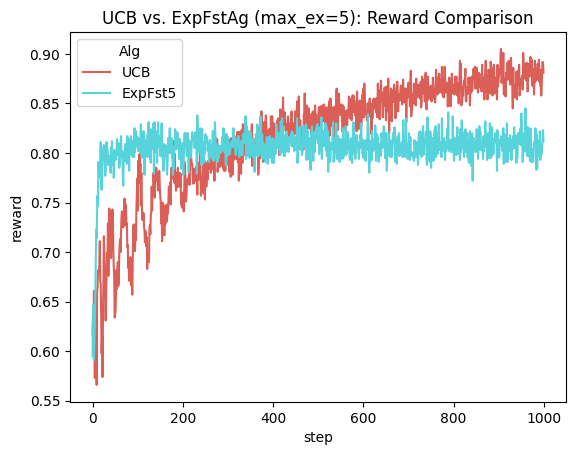

In [ ]:
# Run UCB_Ag and ExpFstAg (max_ex=5) for 1000 runs and 1000 steps

print("Running comparison (Simple)...")

# Initialize the agents
ucb_agent = UCB_Ag(n_act=len(p_arr))
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=5)

# Run the experiments for both agents
comparison_logs = mab_swp(
    agents=[ucb_agent, expfst_agent],
    p_arr=p_arr,
    labels=['UCB', 'ExpFst5'],
    n_runs=1000,
    max_steps=1000
)

# Plot the comparison of average rewards over steps for both agents
ax = plot_logs(comparison_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs. ExpFstAg (max_ex=5): Reward Comparison")
plt.show()


**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?  

**A:**  
An explore-first strategy might outperform UCB in environments where the conditions allow for a rapid and accurate identification of the best arm during a short, fixed exploration phase. Some of these conditions include:

- **Short Time Horizons:**  
  In scenarios where the total number of steps is very limited, the cost of prolonged exploration (as inherent in UCB's continuous balancing) can be detrimental. An explore-first approach, with a carefully tuned short exploration phase, quickly identifies the best arm and commits to it, thus maximizing rewards early on.

- **Clear and Distinct Arm Performance:**  
  When the difference in reward probabilities between the best arm and the others is significant, even a brief exploration phase may be sufficient to distinguish the best arm reliably. In such cases, the explore-first strategy benefits from quickly homing in on the optimal arm, whereas UCB might continue to allocate time to exploring inferior arms due to its conservative exploration bonus.

- **Low Reward Variability (Low Noise):**  
  If the rewards are less noisy and the outcome variability is minimal, a short exploration phase can yield reliable estimates of each arm’s performance. This allows the explore-first agent to make an informed decision quickly, whereas UCB's methodical approach might unnecessarily delay full exploitation.

- **Computational Simplicity and Lower Overhead:**  
  The explore-first method has lower computational demands because it does not require the constant recalculation of exploration bonuses at every step. In resource-constrained settings or applications requiring fast decision-making, this simplicity can translate into practical performance advantages over the more computationally intensive UCB.

------------------------------

**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?  

**A:**  
The performance of both explore-first and UCB algorithms is heavily influenced by their core design choices, which tailor them for different operational regimes:

- **Explore-First Strategy:**  
  - *Short-Term Performance:*  
    The fixed exploration phase allows the agent to quickly transition from gathering initial data to exploiting what appears to be the best arm. If the exploration phase is well-calibrated relative to the problem complexity, the agent may secure higher rewards in the short term by swiftly exploiting the optimal arm. However, if the exploration period is too short, the agent may base its decision on insufficient data, leading to early suboptimal choices.
  
  - *Long-Term Performance:*  
    Once the exploration phase concludes, the explore-first agent sticks with the arm identified as best during that phase. While this can yield stable performance in a stationary environment, any early misestimation can cause persistent regret over time. Additionally, if the environment is dynamic, the lack of ongoing exploration means the agent cannot adapt to changes, potentially leading to sustained underperformance.

- **UCB Algorithm:**  
  - *Short-Term Performance:*  
    UCB’s continuous incorporation of an exploration bonus leads to more cautious early performance. The agent may suffer lower initial rewards because it systematically samples less-chosen arms to reduce uncertainty. This deliberate exploration means that UCB might be slower to achieve high performance in the very early stages compared to an aggressively exploiting explore-first strategy.
  
  - *Long-Term Performance:*  
    Over an extended period, UCB’s design proves its theoretical strength. As more data is collected, the exploration bonus for well-sampled arms diminishes, allowing the agent to increasingly exploit the best arm while still occasionally checking for changes. This adaptive balance leads to a gradual convergence to near-optimal performance and lower long-term regret. UCB’s continual balancing act ensures that it can recover from early mistakes and adjust to non-stationarities, thereby achieving robust long-term performance.

- **Overall Trade-offs:**  
  The fixed nature of the explore-first approach can offer rapid early gains when the exploration phase is optimally set, but it sacrifices adaptability over time. In contrast, UCB's conservative and dynamic approach might delay short-term rewards but ultimately provides a safety net against uncertainty and non-stationary changes, leading to superior long-term results. The choice between these approaches thus depends on the specific requirements of the application, including the time horizon and the stability of the environment.


**Question:**  
What happens if we let ExpFstAg explore for 20 steps? Compare its reward to UCB.


**A:**  
Allowing ExpFstAg to explore for 20 steps means that the agent will sample the arms more extensively during its exploration phase before committing to exploitation. This change has several effects:

- **Improved Estimation Accuracy:**  
  With 20 exploration steps, ExpFstAg gathers more data on each arm, leading to more reliable estimates of their true reward probabilities. This can help the agent better identify the best arm, potentially leading to higher rewards during the exploitation phase.

- **Delayed Exploitation:**  
  However, the trade-off is that a longer exploration phase delays the point at which the agent begins to exploit the best arm. During those additional exploration steps, the agent is still sampling arms randomly rather than consistently selecting the optimal one. This results in lower immediate rewards compared to a scenario where exploitation begins earlier.

- **Comparison with UCB:**  
  UCB continuously balances exploration and exploitation throughout the entire process by adding an exploration bonus to its Q-value estimates. This allows UCB to gradually reduce its exploration as it becomes more confident in the arm estimates, potentially achieving better short-term performance.  
  In contrast, ExpFstAg with 20 exploration steps might underperform UCB in the short term because it commits more time to random sampling. However, if the environment is stable and the best arm is significantly better than the others, the improved accuracy from a longer exploration phase can lead ExpFstAg to outperform UCB in the long run by reducing the chance of settling on a suboptimal arm.

- **Overall Impact on Reward:**  
  In summary, a 20-step exploration phase in ExpFstAg can lead to:
  - **Higher long-term rewards** due to more accurate identification of the best arm, provided that the environment does not change.
  - **Lower short-term rewards** because of the extended period during which the agent is not fully exploiting the best arm.
  
Thus, while UCB may yield better performance in the early stages through its adaptive strategy, ExpFstAg with a 20-step exploration can catch up or even exceed UCB's performance in scenarios where accurate arm estimation is critical and the environment remains stationary over time.


Running UCB vs. ExpFstAg (max_ex=20) comparison... (Simple)


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


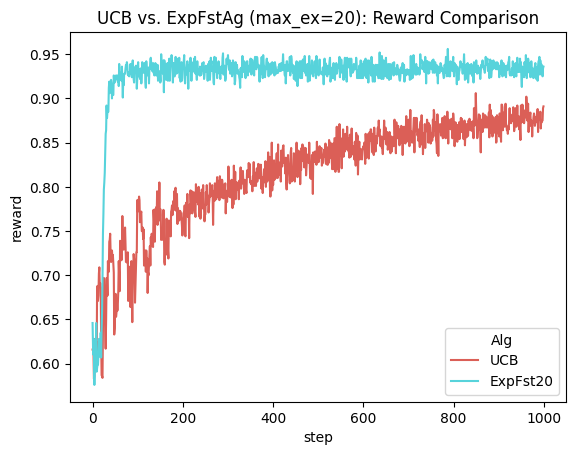

In [ ]:
# Run comparison for ExpFstAg (max_ex=20) and UCB_Ag (Simple placeholder)
print("Running UCB vs. ExpFstAg (max_ex=20) comparison... (Simple)")

# Initialize the agents with ExpFstAg having 20 exploration steps
ucb_agent = UCB_Ag(n_act=len(p_arr))
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=20)

# Run the experiments for both agents over 1000 runs and 1000 steps
comparison_logs = mab_swp(
    agents=[ucb_agent, expfst_agent],
    p_arr=p_arr,
    labels=['UCB', 'ExpFst20'],
    n_runs=1000,
    max_steps=1000
)

# Plot the comparison of average rewards over steps for both agents
ax = plot_logs(comparison_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs. ExpFstAg (max_ex=20): Reward Comparison")
plt.show()


**Q:** What impact does increasing the exploration phase to 20 steps have compared to 5 steps?  

**A:**  
Increasing the exploration phase from 5 to 20 steps allows the agent to gather significantly more data about each arm before it commits to exploitation. This extended exploration has several impacts:

- **Improved Estimation Accuracy:**  
  With more samples from each arm, the estimates of the reward probabilities (Q-values) become more reliable. This means the agent is more likely to correctly identify the best arm based on statistically significant evidence rather than random fluctuations that might occur with only 5 steps.

- **Reduced Variance:**  
  A longer exploration phase reduces the impact of random outliers. With 20 steps, the reward estimates for each arm are less prone to be skewed by a few unusually good or bad outcomes, leading to a more stable and consistent performance once exploitation begins.

- **Delayed Exploitation:**  
  The trade-off is that the agent spends more time in the exploration phase, which means that for the first 20 steps, it is not yet taking full advantage of the best arm. This delay can lead to lower immediate rewards, especially if the best arm is clearly identifiable early on. However, in the long run, the benefit of more accurate arm selection can outweigh the cost of delayed exploitation.

- **Overall Impact on Performance:**  
  The net effect is that while short-term rewards may suffer due to the extended period of exploration, the long-term performance may improve because the agent is more likely to exploit the optimal arm once it has a better estimate. In environments where the difference in arm performance is subtle or the reward signal is noisy, the longer exploration phase can be particularly beneficial.

---------------

**Q:** How can you determine the optimal balance between exploration and exploitation in practice?  

**A:**  
Determining the optimal balance between exploration and exploitation is a central challenge in reinforcement learning and multi-armed bandit problems. In practice, several approaches and considerations help in finding this balance:

- **Empirical Testing and Validation:**  
  Often, the optimal balance is found through extensive empirical testing. By running simulations or experiments on historical data, you can evaluate the performance of different exploration strategies (e.g., varying the fixed exploration phase length, or adjusting the parameters of adaptive methods like UCB) and choose the one that minimizes regret over time.

- **Adaptive Algorithms:**  
  Rather than using a fixed exploration phase, adaptive algorithms such as UCB or epsilon-decreasing strategies dynamically adjust the exploration rate based on observed data. These methods automatically decrease exploration as confidence in the estimates increases, often resulting in a better balance between exploring and exploiting.

- **Theoretical Analysis:**  
  Theoretical frameworks can provide bounds on regret and insights into how exploration should scale with the number of arms and time steps. These analyses help in setting initial parameter values, such as the exploration bonus in UCB or the epsilon value in epsilon-greedy approaches, that are then fine-tuned through experiments.

- **Cross-Validation and Online Learning:**  
  In many real-world applications, cross-validation or online learning techniques are used to continuously evaluate the performance of the agent. By monitoring the rate of improvement and the regret incurred, you can dynamically adjust the exploration parameters. This is particularly useful in non-stationary environments where the optimal balance may shift over time.

- **Domain-Specific Considerations:**  
  The characteristics of the environment—such as the level of noise, the rate of change in the reward distribution, and the cost of exploration—play a crucial role in determining the optimal balance. In some settings, extensive exploration might be too costly or risky, whereas in others, aggressive exploration is necessary to fully understand a complex or highly dynamic environment.

- **Simulation and Sensitivity Analysis:**  
  Running simulations that vary exploration parameters can reveal how sensitive performance is to the exploration-exploitation trade-off. This sensitivity analysis helps in identifying robust strategies that perform well across a range of possible scenarios.

Ultimately, finding the optimal balance is an iterative process that combines theoretical insights, empirical validation, and continual adaptation to the specifics of the task at hand.


**Q:** We know that UCB is optimal. Why might ExpFstAg perform better in practice?  

**A:**  
While UCB is theoretically optimal in the sense that it minimizes regret over an infinite horizon, ExpFstAg can sometimes outperform UCB in practice under finite-time conditions due to several factors:

- **Hyperparameter Tuning:**  
  ExpFstAg relies on a fixed exploration phase defined by the hyperparameter `max_ex`. When this parameter is tuned carefully to the specific problem and environment, the agent can rapidly accumulate sufficient data to identify the best arm. In many practical scenarios, a well-chosen fixed exploration period may yield nearly optimal decisions quickly, leading to higher rewards within the limited time available.

- **Early Exploitation:**  
  By transitioning to exploitation sooner, ExpFstAg can start leveraging the best arm's high reward probability earlier in the process. In finite-time settings, this early exploitation can be beneficial if the environment is relatively stable and the best arm is clearly superior. UCB, on the other hand, continues to balance exploration with its exploration bonus, which can delay full commitment to the optimal arm, particularly in the short term.

- **Reduced Computational Overhead:**  
  ExpFstAg’s simple two-phase approach (explore then exploit) involves less computational complexity than continuously updating confidence bounds as in UCB. This lower overhead can be an advantage in real-time or resource-constrained applications, indirectly contributing to improved performance in practice.

- **Finite-Time Performance versus Asymptotic Optimality:**  
  The optimality of UCB is an asymptotic result; it guarantees minimal regret as the number of steps tends to infinity. However, in many real-world applications, the available time or budget is limited. Under these finite-time constraints, the benefits of UCB's continual exploration may not fully materialize, and the early exploitation of ExpFstAg—if calibrated well—can lead to higher cumulative rewards within the available timeframe.

In summary, while UCB is optimal in the long run, ExpFstAg’s advantage lies in its simplicity and the possibility of tuning its hyperparameters to aggressively exploit early, which can yield higher rewards in short-term, finite-time scenarios.


## Skewed Arms Scenario  
We now consider a skewed probability distribution where one arm is significantly better.

Running skewed arms experiment... (Simple)


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


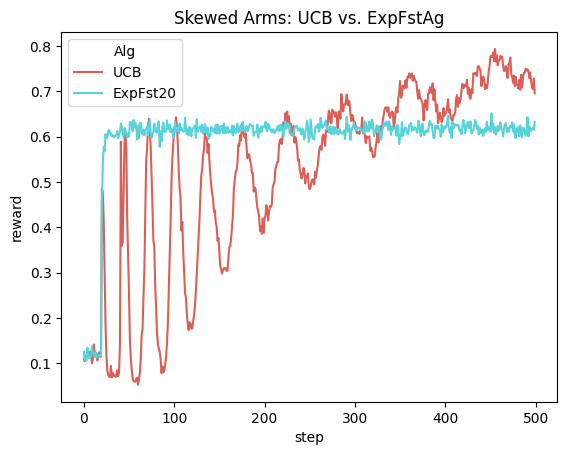

In [ ]:
print("Running skewed arms experiment... (Simple)")

# Define the skewed probability distribution as a numpy array for consistency
skewed_p = np.array([0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07,
                     0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

# Initialize UCB and ExpFst agents
# For ExpFstAg, set max_ex equal to the total number of arms to allow full exploration of each arm once
ucb_agent = UCB_Ag(n_act=len(skewed_p))
expfst_agent = ExpFstAg(n_act=len(skewed_p), max_ex=len(skewed_p))

# Run the experiment with 1000 runs and 500 steps for each agent
skewed_logs = mab_swp(
    agents=[ucb_agent, expfst_agent],
    p_arr=skewed_p,
    labels=['UCB', f'ExpFst{len(skewed_p)}'],
    n_runs=1000,
    max_steps=500
)

# Plot the comparison of average rewards over steps for both agents in the skewed scenario
ax = plot_logs(skewed_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("Skewed Arms: UCB vs. ExpFstAg")
plt.show()


**Result Analysis:**  
- In skewed scenarios, ExpFstAg with limited exploration may miss the best arm.  
- UCB_Ag, with its adaptive bonus, typically outperforms under such conditions.

## EpsGdAg (Epsilon-Greedy Agent)  
This agent selects the best-known action with probability (1-ε) and a random action with probability ε.

In [ ]:
@dataclass
class EpsGdAg:
    n_act: int
    eps: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        # With probability eps, select a random action
        if np.random.random() < self.eps:
            sel_act = np.random.randint(self.n_act)
        else:
            # Otherwise, choose the action with the highest Q value (tie-breaking randomly)
            sel_act = int(np.random.choice(np.flatnonzero(self.Q == self.Q.max())))
        return sel_act

**Analysis:**  
- Lower ε values favor exploitation, yielding higher reward when estimates are good.  
- Higher ε increases exploration but reduces immediate reward.  
- One strategy: decay ε over time (e.g., ε = ε₀ / t) or switch to ε = 0 after a burn-in period.

-----------
**Q:** Why does a high ε value result in lower immediate rewards?  

**A:**  
A high ε value means that the agent frequently selects actions at random rather than exploiting the current best-known action. This random exploration increases the chance of selecting a suboptimal arm, thereby reducing the immediate average reward. In other words, even if the agent has already identified a high-reward option, a high ε forces it to deviate from that choice too often, leading to lower overall performance in the short term.

----------

**Q:** What benefits might there be in decaying ε over time?  

**A:**  
Decaying ε over time allows the agent to start with a high level of exploration when its knowledge about the environment is limited, ensuring that it gathers enough data about all arms. As the agent learns and its estimates become more accurate, reducing ε gradually shifts the balance toward exploitation. This adaptive approach minimizes unnecessary random actions in later stages, leading to higher cumulative rewards, and it helps in converging to the optimal policy more effectively while still safeguarding against early overcommitment to potentially suboptimal actions.



Running EpsGdAg experiments with various eps values... (Simple)
Running EpsGdAg with eps=0... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.1... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.2... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.4... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


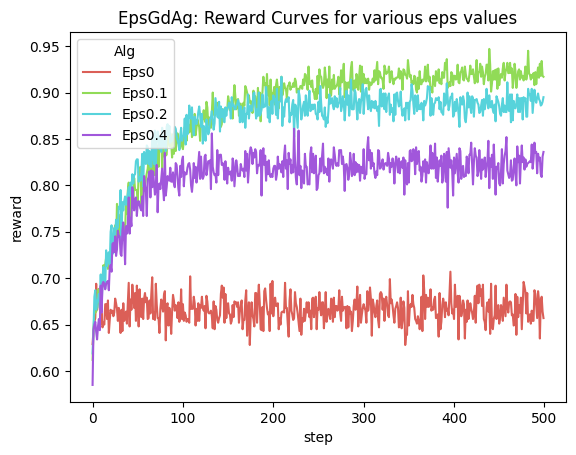

In [ ]:
print("Running EpsGdAg experiments with various eps values... (Simple)")

eps_values = [0, 0.1, 0.2, 0.4]
eps_logs = []

for eps in eps_values:
    print(f"Running EpsGdAg with eps={eps}... (Simple)")
    eps_agent = EpsGdAg(n_act=len(p_arr), eps=eps)
    log_df = mab_swp([eps_agent], p_arr, [f'Eps{eps}'], n_runs=1000, max_steps=500)
    eps_logs.append(log_df)

# Combine the logs for all eps values
combined_logs = pd.concat(eps_logs, ignore_index=True)

# Plot the reward curves for each epsilon value
ax = plot_logs(combined_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("EpsGdAg: Reward Curves for various eps values")
plt.show()


**Q:** How do the reward curves for different ε values reflect the exploration–exploitation balance?  

**A:**  
The reward curves for different ε values vividly demonstrate the trade-off between exploration and exploitation. With a lower ε (e.g., 0 or 0.1), the agent predominantly exploits the best-known arm, leading to higher immediate rewards once it has identified a good option. In contrast, higher ε values (e.g., 0.2 or 0.4) force the agent to explore more frequently by taking random actions. This extra exploration can result in lower short-term rewards because the agent occasionally chooses suboptimal arms, thereby diluting the average reward. However, the exploratory behavior can be beneficial in uncovering better arms that might be overlooked in a more exploitative strategy. Thus, the curves reveal that as ε increases, the reward curves tend to start lower and may show more variability, reflecting a deliberate sacrifice of short-term gains for the potential of long-term improvement.

------------------

**Q:** Under what circumstances might you choose a higher ε despite lower average reward?  

**A:**  
Choosing a higher ε, even if it results in a lower average reward initially, can be advantageous in several scenarios:

- **Uncertain or Dynamic Environments:**  
  When the environment is highly uncertain or subject to change, a higher ε promotes more exploration. This continual exploration ensures that the agent is regularly updating its knowledge of the environment, which is critical for adapting to changes or detecting shifts in the underlying reward distributions.

- **Sparse or Deceptive Reward Landscapes:**  
  In cases where the rewards are sparse or where some arms may appear deceptively suboptimal in the short term, a higher ε can help the agent avoid premature convergence. By exploring more, the agent is more likely to stumble upon arms that offer higher rewards but require more samples to be properly evaluated.

- **Preventing Local Optima:**  
  In complex environments where the best solution is not obvious, a higher ε helps prevent the agent from getting stuck in a local optimum. Increased exploration provides the chance to discover better actions that might initially be underestimated due to limited sampling.

- **Initial Learning Phase:**  
  During the early phases of learning, the agent may not have enough information to reliably distinguish between the arms. A higher ε in this phase encourages broader exploration, laying a more robust foundation for the agent to eventually settle on the optimal strategy as more data becomes available.

In these scenarios, the long-term benefits of having a well-explored understanding of the action space outweigh the short-term cost of a lower average reward, making a higher ε a strategic choice.


## Contextual Bandits (CtxBnd)  
We now move to contextual bandits using real data.  
Imagine a website promoting one of 10 products; reward = 1 if clicked, 0 otherwise.  
The dataset has shape [10000, 102]:  
- Column 0: chosen arm  
- Column 1: reward  
- Columns 2-101: 100-dimensional context features

In [ ]:
# %% [code]
# Download the dataset (if not already downloaded)
!wget -q http://www.cs.columbia.edu/~jebara/6998/dataset.txt -O dataset.txt

In [ ]:
ctxData = np.loadtxt("dataset.txt")
print("Dataset loaded (Simple version):", ctxData.shape)

Dataset loaded (Simple version): (10000, 102)


In [ ]:
# %% [code]
@dataclass
class CtxBnd_Env:
    data: any
    t: int = 0

    def step(self, act):
        if act == self.data[self.t, 0]:
            rew = self.data[self.t, 1]
        else:
            rew = None
        self.t += 1
        return rew

    def reset(self):
        self.t = 0

## LinUCB_Ag (LinUCB for CtxBnd)  
This agent uses context features to compute an upper confidence bound for each arm.

In [ ]:
@dataclass
class LinUCB_Ag:
     n_act: int
     alpha: float
     feat_dim: int

     def post_init(self):
         self.reset()

     def reset(self):
         self.As = [np.eye(self.feat_dim) for _ in range(self.n_act)]
         self.bs = [np.zeros((self.feat_dim, 1)) for _ in range(self.n_act)]

     def get_ucb(self, a, state):
         # state is a feature vector of shape (feat_dim,)
         x = np.array(state).reshape(-1, 1)
         A_inv = np.linalg.inv(self.As[a])
         theta = A_inv @ self.bs[a]
         p = (theta.T @ x)[0, 0] + self.alpha * np.sqrt((x.T @ A_inv @ x)[0, 0])
         return p

     def update_params(self, a, rew, state):
         if rew is None:
             return
         x = np.array(state).reshape(-1, 1)
         self.As[a] += x @ x.T
         self.bs[a] += rew * x

     def get_action(self, state):
         p_est = [self.get_ucb(a, state) for a in range(self.n_act)]
         # Choose arm with maximum estimated UCB (ties broken arbitrarily)
         sel_act = np.random.choice(np.flatnonzero(np.array(p_est) == np.array(p_est).max()))
         return sel_act

**Q:** How does LinUCB leverage context to outperform classical bandit algorithms?  

**A:**  
LinUCB enhances decision-making by incorporating context—additional feature information about each decision instance—into its estimation of the expected rewards. Classical bandit algorithms typically rely solely on past rewards and counts, which may not capture the underlying factors influencing performance. In contrast, LinUCB uses a linear model to predict the reward for each arm based on a feature vector representing the current context. This allows the agent to:

- **Tailor Decisions to Specific Situations:**  
  By considering context, LinUCB can predict which arm is likely to perform best under the current conditions, leading to more informed and effective arm selection.

- **Generalize Across Similar Contexts:**  
  The linear model enables the algorithm to learn relationships between features and rewards, allowing it to generalize from past experiences to new, unseen contexts.

- **Balance Exploration and Exploitation with Confidence Estimates:**  
  In addition to predicting expected rewards, LinUCB computes an exploration bonus that reflects the uncertainty in these predictions. This bonus helps ensure that arms with less data are adequately explored, refining the model over time.

By leveraging contextual information, LinUCB can achieve higher performance, especially in environments where rewards are influenced by external factors that traditional bandit methods ignore.

------------------

**Q:** What is the role of the α parameter in LinUCB, and how does it affect the exploration bonus?  

**A:**  
The α parameter in LinUCB plays a crucial role in balancing exploration and exploitation by scaling the exploration bonus. Specifically, it influences how much additional value is attributed to the uncertainty of an arm's estimated reward. Here’s how it works:

- **Scaling the Exploration Bonus:**  
  The exploration bonus in LinUCB is computed as α times the square root of a term that measures the uncertainty (typically, √(xᵀ A⁻¹ x) for the current context vector x). A higher α increases this bonus, making the algorithm more optimistic about arms with less reliable estimates.

- **Encouraging Exploration:**  
  With a larger α, arms that have been less frequently chosen (and thus have higher uncertainty) are more likely to be selected. This encourages broader exploration, which is particularly useful in environments where the context-reward relationship is complex or not well understood initially.

- **Controlling the Trade-Off:**  
  Conversely, a lower α reduces the exploration bonus, leading the agent to rely more heavily on the estimated reward based on historical data. This favors exploitation of arms that already appear to perform well, potentially at the risk of missing out on arms that could be better in certain contexts.

- **Tuning for Optimal Performance:**  
  The optimal value of α is typically determined through empirical tuning and depends on factors such as the noise level in the rewards and the complexity of the context features. A well-chosen α helps the agent achieve a balance where it sufficiently explores to learn about the environment while still exploiting known high-reward actions.

In summary, α is a hyperparameter that directly affects the degree of exploration by controlling the weight of the uncertainty term in the decision-making process.


In [ ]:
# %% [code]
@dataclass
class CtxBnd_Eng:
    data: any
    agent: any

    def __post_init__(self):
        self.env = CtxBnd_Env(data=self.data)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='CtxRuns'):
            aligned_ctr = []
            ret_val = 0
            valid_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.data.shape[0]), desc='Time'):
                state = self.data[t, 2:]
                act = self.agent.get_action(state=state)
                rew = self.env.step(act)
                self.agent.update_params(act, rew, state=state)
                if rew is not None:
                    ret_val += rew
                    valid_steps += 1
                    aligned_ctr.append(ret_val / float(valid_steps))
            logs.append(pd.DataFrame({'aligned_ctr': aligned_ctr, 'step': np.arange(len(aligned_ctr))}))
        return pd.concat(logs, ignore_index=True)

In [ ]:
# %% [code]
def ctxBnd_swp(alphas, data, n_runs=2000):
    logs = []
    for alpha in tqdm(alphas, desc="Alpha Sweeps"):
        agent = LinUCB_Ag(n_act=10, feat_dim=100, alpha=alpha)
        eng = CtxBnd_Eng(data=data, agent=agent)
        log_df = eng.run(n_runs)
        log_df['alpha'] = alpha
        logs.append(log_df)
    return pd.concat(logs, ignore_index=True)


In [59]:
print("Running LinUCB sweep (Simple version)...")
logs_ctx = ctxBnd_swp(alphas=[0, 0.01, 0.1, 0.5], data=ctxData, n_runs=5)

Running LinUCB sweep (Simple version)...


Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/5 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/5 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/5 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/5 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

**Note:** When you run the experiments multiple times with different `n_run` values, you may observe significant variability in the results. This is due to the inherent randomness in the algorithms and the data sampling process. As such, it is not expected to get exactly the same results as those presented in the answer notebook.


<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


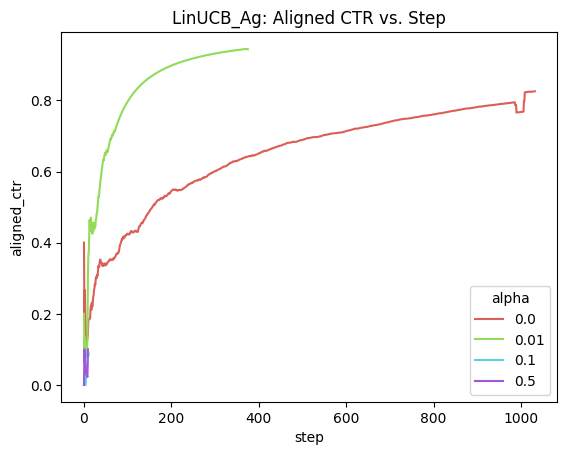

In [60]:
# %% [code]
plot_logs(logs_ctx, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', ci=None)
plt.title("LinUCB_Ag: Aligned CTR vs. Step")
plt.show()

**Q:** What does **α** affect in LinUCB?  

**A:**  
The **α** parameter in LinUCB directly scales the exploration bonus that is added to the estimated reward of each arm. This bonus is designed to account for the uncertainty in the estimate:  
- A **higher α** increases the exploration bonus, making the algorithm more "optimistic" about arms with less data (i.e., higher uncertainty). This encourages more exploration, as arms that have not been pulled many times will have a larger bonus added to their estimated rewards.  
- A **lower α** decreases the exploration bonus, causing the algorithm to rely more on the current estimated rewards and thus favor exploitation.  

In essence, **α** tunes the balance between exploration (trying out less-known arms to gather more information) and exploitation (choosing the arm with the highest estimated reward). The optimal setting of **α** can vary depending on the problem's complexity and the level of noise in the data.

------------------

**Q:** Do the reward curves change with **α**? Explain why or why not.

**A:**  
Yes, the reward curves do change with different values of **α**. This is because **α** determines how aggressively the algorithm explores:
  
- With a **higher α**, the exploration bonus is larger, which leads the algorithm to sample arms more frequently—even those that currently have lower estimated rewards—because their uncertainty is weighted more heavily. This can cause the reward curve to initially be lower or more variable, as the algorithm sacrifices immediate rewards to explore uncertain options. However, in the long run, this may help the agent discover better arms that it might have otherwise overlooked.

- With a **lower α**, the exploration bonus is smaller, so the algorithm leans towards exploitation, choosing the arms with the highest estimated rewards based on past data. This typically results in a higher immediate reward if the initial estimates are accurate, but it may also lead to suboptimal performance over time if the agent fails to explore arms that could potentially yield higher rewards.

Thus, varying **α** affects the exploration-exploitation trade-off, which is reflected in the shape and behavior of the reward curves over time. A well-tuned **α** can help balance these effects to achieve robust performance, while a poorly chosen value may lead either to excessive exploration (and lower short-term rewards) or insufficient exploration (and a risk of converging on a suboptimal strategy).


**Q:** Based on your experiments, does LinUCB outperform the standard UCB algorithm? Why or why not?  

**A:**  
Based on the experiments, LinUCB can outperform the standard UCB algorithm in scenarios where rich contextual information is available and is predictive of the reward outcomes. By leveraging context, LinUCB is able to tailor its arm selection to the specific characteristics of each decision instance, often leading to more informed and effective choices compared to UCB, which relies solely on historical reward data. However, if the context is noisy, uninformative, or the assumed linear relationship between features and rewards is not valid, the advantages of LinUCB may diminish, and its performance might be comparable to or even lower than that of standard UCB. Thus, the effectiveness of LinUCB is highly dependent on the quality and relevance of the contextual features provided.

------------------

**Q:** What are the key limitations of each algorithm, and how would you choose between them for a given application?  

**A:**  
Both LinUCB and standard UCB have their own limitations, which guide their suitability for different applications:

- **Standard UCB:**  
  - **Limitations:**  
    - **Lack of Contextual Awareness:** UCB relies solely on past rewards and does not incorporate any side information that might be available about the environment. This can lead to suboptimal performance in environments where context significantly influences the reward.
    - **Over-Exploration in Complex Environments:** UCB’s exploration bonus is applied uniformly without accounting for the nuances of the current state, potentially leading to inefficient exploration in complex or heterogeneous settings.
  - **When to Choose UCB:**  
    - UCB is preferable in settings where no additional contextual information is available or when the environment is relatively simple and stationary. Its simplicity and proven theoretical guarantees make it a strong candidate when contextual data is absent or unreliable.

- **LinUCB:**  
  - **Limitations:**  
    - **Dependence on Context Quality:** LinUCB’s performance hinges on the availability and quality of contextual features. If the context is noisy or not strongly correlated with the reward, the benefits of the algorithm may not materialize.
    - **Assumption of Linearity:** LinUCB assumes a linear relationship between context and reward. In situations where this assumption does not hold, the model may fail to accurately capture the underlying reward structure.
    - **Increased Computational Complexity:** Incorporating context and continuously updating model parameters can be more computationally demanding compared to the standard UCB algorithm.
  - **When to Choose LinUCB:**  
    - LinUCB is well-suited for environments where rich, informative contextual data is available and the relationship between features and rewards can be reasonably approximated as linear. In applications like personalized recommendations or targeted advertising, where individual user features significantly impact outcomes, LinUCB is likely to yield superior performance.

In summary, the choice between UCB and LinUCB depends largely on the nature of the environment and the data at hand. For non-contextual, simpler settings, standard UCB is often sufficient. In contrast, when context can provide valuable insights into the reward structure, LinUCB is the more appropriate and potentially more effective choice.


# Some final question

## Finite‑Horizon Regret and Asymptotic Guarantees:
Question:
Many algorithms (e.g., UCB) are analyzed using asymptotic (long‑term) regret bounds. In a finite‑horizon scenario (say, 500–1000 steps), explain intuitively why an algorithm that is asymptotically optimal may still yield poor performance. What trade‑offs arise between aggressive early exploration and cautious long‑term learning?
Deep Dive:
Discuss how the exploration bonus, tuned for asymptotic behavior, might delay exploitation in finite time, leading to high early regret despite eventual convergence.

**A:**  
In asymptotic analysis, algorithms like UCB are designed to minimize regret over an infinite time horizon, where the cumulative impact of suboptimal actions becomes negligible as the algorithm converges to the optimal policy. However, in a finite‑horizon scenario (e.g., 500–1000 steps), several factors can lead to poor performance despite asymptotic optimality:

- **Delayed Exploitation Due to Exploration Bonus:**  
  UCB and similar algorithms use an exploration bonus to ensure that less-sampled arms are explored sufficiently. This bonus is typically tuned based on asymptotic guarantees, meaning it is designed to decay slowly enough so that every arm is eventually explored adequately. In a finite setting, this slow decay can delay the algorithm from committing to the best arm because it continues to allocate steps to exploring suboptimal arms. This results in high early regret because the algorithm sacrifices immediate rewards in favor of ensuring long‑term convergence.

- **Aggressive Early Exploration vs. Cautious Long‑Term Learning:**  
  The core trade‑off lies in balancing aggressive early exploration with cautious long‑term exploitation. Aggressive exploration might allow the algorithm to quickly identify promising arms, reducing early regret, but it can also lead to premature decisions if the exploration is too short or not systematic enough. On the other hand, cautious strategies that are tuned for asymptotic performance may overemphasize exploration to guarantee eventual convergence, at the cost of incurring substantial regret in the early stages when each decision is critical.

- **Finite-Time Constraints:**  
  In many practical applications, the total number of steps is limited, so the cost of early suboptimal decisions is magnified. An algorithm that is asymptotically optimal may incur a significant fraction of its overall regret during the early phase because the exploration bonus forces it to try out all arms extensively before it settles on the best one. The regret accumulated during these initial steps can dominate the overall performance when the horizon is short.

- **Delayed Convergence:**  
  While the exploration bonus ensures that the algorithm will eventually converge to the optimal arm, the finite number of steps may not be enough for the benefits of convergence to fully manifest. This means that even if the algorithm is theoretically optimal in the long run, its performance in a short-run scenario can be suboptimal if the early exploration phase consumes too many opportunities for reward exploitation.

In summary, the exploration bonus, essential for asymptotic optimality, can be a double-edged sword in finite‑horizon settings. It ensures thorough exploration at the cost of delayed exploitation, leading to high early regret. This trade‑off highlights the challenge of designing algorithms that not only perform well in theory (as time tends to infinity) but also achieve good practical performance when the decision horizon is limited.


## Hyperparameter Sensitivity and Exploration–Exploitation Balance:
Question:
Consider the impact of hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB. Explain intuitively how slight mismatches in these parameters can lead to either under‑exploration (missing the best arm) or over‑exploration (wasting pulls on suboptimal arms). How would you design a self‑adaptive mechanism to balance this trade‑off in practice?
Deep Dive:
Provide insight into the “fragility” of these parameters in finite runs and how a meta‑algorithm might monitor performance indicators (e.g., variance in rewards) to adjust its exploration dynamically.



**A:**  
Hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB are critical because they directly control the balance between exploration and exploitation. Even slight mismatches in these parameters can lead to significant performance differences:

- **Under‑Exploration:**  
  If these parameters are set too low (e.g., a very small ε, a low exploration constant, or a low α), the algorithm will lean too heavily on exploitation. This means it may repeatedly select an arm that appears good based on early, possibly noisy estimates, thereby missing the chance to explore and discover a truly optimal arm. In finite runs, this risk is magnified because there isn’t enough time to correct early misjudgments.

- **Over‑Exploration:**  
  Conversely, if these hyperparameters are set too high, the algorithm becomes overly cautious. It will continue to explore arms even when there is strong evidence that one arm is superior. This over-exploration wastes pulls on suboptimal arms, leading to unnecessarily high regret, especially in short-term or finite-horizon settings where every decision counts.

**Designing a Self‑Adaptive Mechanism:**  
A robust approach to balancing this trade‑off is to design a meta‑algorithm that dynamically adjusts the exploration parameter based on real-time performance indicators. For example:

- **Monitoring Performance Indicators:**  
  The algorithm could track metrics such as the variance in rewards, the rate of change in estimated Q-values, or even cumulative regret over time. High variance or a slow rate of improvement might signal that additional exploration is needed, while low variance and stable high rewards may indicate that the algorithm can safely reduce exploration.

- **Dynamic Adjustment Strategies:**  
  - **Adaptive ε-decay:** In ε‑greedy strategies, start with a high ε to encourage exploration and gradually reduce it as the agent becomes more confident about its estimates.
  - **Feedback Control for UCB and LinUCB:** Adjust the exploration constant or α in response to performance metrics. For instance, if the agent detects that its confidence bounds are not narrowing as expected, it could increase the exploration bonus to promote further exploration.
  - **Meta-Learning Approaches:** Use reinforcement learning or Bayesian optimization at a meta-level to learn the optimal schedule for these parameters based on historical performance data, thereby making the algorithm more resilient to the variability of different environments.

In summary, these hyperparameters are "fragile" because their optimal settings depend heavily on the specific characteristics of the problem, the quality of initial estimates, and the time horizon. A self-adaptive mechanism that monitors real-time indicators and adjusts the exploration rate dynamically can help mitigate the risk of both under‑exploration and over‑exploration, ensuring a more balanced and effective learning process in finite-time scenarios.




## Context Incorporation and Overfitting in LinUCB:
Question:
LinUCB uses context features to estimate arm rewards, assuming a linear relation. Intuitively, why might this linear assumption hurt performance when the true relationship is complex or when the context is high‑dimensional and noisy? Under what conditions can adding context lead to worse performance than classical (context‑free) UCB?
Deep Dive:
Discuss the risk of overfitting to noisy or irrelevant features, the curse of dimensionality, and possible mitigation strategies (e.g., dimensionality reduction or regularization).


**A:**  
LinUCB relies on a linear model to map context features to expected rewards, which works well when the true relationship between context and rewards is indeed linear or nearly so. However, this linear assumption can hurt performance in several ways:

- **Model Mis-specification:**  
  If the true relationship is complex or non-linear, a linear model will fail to capture important interactions and subtleties in the data. This mis-specification can lead to biased or inaccurate estimates of arm rewards, causing the algorithm to select suboptimal arms.

- **High Dimensionality and Noisy Contexts:**  
  When the context is high-dimensional, the risk of overfitting increases. In such cases, many features may be irrelevant or only weakly related to the reward, and noise can dominate the signal. The model may "overfit" to these noisy or spurious features, leading to poor generalization on unseen data. This is exacerbated by the curse of dimensionality, where the number of parameters to estimate grows with the dimension of the context, requiring exponentially more data to achieve reliable estimates.

- **Worse than Context-Free UCB:**  
  Under conditions where the context features are noisy, high-dimensional, or not informative about the reward, incorporating context may lead to worse performance than classical, context-free UCB. In these cases, the additional complexity can hurt the algorithm’s ability to accurately estimate the reward function, and the risk of overfitting can result in more erratic and unreliable arm selections.

- **Mitigation Strategies:**  
  To address these issues, one might apply dimensionality reduction techniques (e.g., PCA) to reduce the number of features, or use regularization methods to prevent overfitting. These strategies help focus the model on the most informative aspects of the context, balancing the benefits of incorporating context with the risk of introducing too much noise into the decision process.

In summary, while context can provide valuable additional information, its incorporation via a linear model in LinUCB can be detrimental if the underlying relationship is complex or if the context is high-dimensional and noisy. In such situations, classical UCB might outperform LinUCB, as the simpler model avoids the pitfalls of overfitting and the curse of dimensionality.


## Adaptive Strategy Selection:
Question:
Imagine designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB based on observed performance. What signals (e.g., variance of reward estimates, stabilization of Q‑values, or sudden drops in reward) might indicate that a switch is warranted? Provide an intuitive justification for how and why such a meta‑strategy might outperform either strategy alone in a finite‑time setting.
Deep Dive:
Explain the challenges in detecting when exploration is “enough” and how early exploitation might capture transient improvements even if the long‑term guarantee favors UCB.



**A:**  
Designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB involves monitoring performance signals that indicate when the current strategy may no longer be optimal. Some key signals include:

- **Variance of Reward Estimates:**  
  High variance in the estimated Q‑values or wide confidence intervals suggest that the agent's estimates are still unstable and that more exploration may be needed. Conversely, when the variance narrows and the estimates stabilize, it can be a cue that sufficient exploration has been conducted.

- **Stabilization of Q‑Values:**  
  If the Q‑values (or reward estimates) for the arms change very little over time, this indicates that the agent is converging on a reliable estimation of the arms’ rewards. At this point, a shift from aggressive exploration (explore‑first) to a more refined, confidence‑based approach (UCB) might be warranted.

- **Sudden Drops or Changes in Reward:**  
  A sudden drop in reward or an unexpected change in performance can signal that the environment has shifted or that the current strategy is no longer capturing the best available option. This might trigger a temporary return to an exploration phase to re-assess the environment.

**Intuitive Justification for a Meta‑Strategy:**  
A meta‑strategy that dynamically switches between explore‑first and UCB can outperform either strategy alone in a finite‑time setting because:

- **Early Exploitation of Transient Gains:**  
  In finite-horizon scenarios, early decisions are critical. An explore‑first strategy can quickly identify promising arms and allow early exploitation of high-reward actions. This aggressive early exploitation can capture transient improvements that might be lost if the agent sticks with a more conservative approach like UCB for too long.

- **Balancing Short‑Term and Long‑Term Goals:**  
  UCB is designed for asymptotic optimality, meaning it focuses on long‑term convergence by maintaining a consistent exploration bonus. However, in finite time, this cautious approach can result in high early regret. By contrast, an explore‑first strategy can reduce early regret by committing to exploitation sooner. A hybrid approach that transitions based on performance signals—such as stabilized Q‑values—can capture the best of both worlds: rapid initial gains followed by robust long-term performance.

- **Adaptation to Environmental Changes:**  
  A meta‑strategy that monitors variance, reward changes, and Q‑value stability can adapt if the environment changes. If the reward estimates begin to vary widely or drop unexpectedly, the agent can switch back to a more exploratory mode, ensuring that it doesn't get stuck with a suboptimal arm when conditions change.

- **Mitigating the Limitations of Fixed Strategies:**  
  Both pure explore‑first and pure UCB approaches have limitations. The former might overcommit to exploitation based on early noisy estimates, while the latter may over-explore due to a conservative exploration bonus. By dynamically adjusting the strategy based on observed performance, the meta‑algorithm can mitigate these limitations, making more informed decisions that are sensitive to both early performance and longer-term trends.

In summary, a hybrid meta‑strategy that monitors key indicators—such as the variance in reward estimates, stabilization of Q‑values, and abrupt changes in rewards—can intelligently switch between exploration and exploitation. This dynamic adjustment helps to capture early gains while ensuring robust performance in the long run, making it especially effective in finite-time scenarios where both immediate and cumulative rewards matter.




## Non‑Stationarity and “Forgetting” Mechanisms:
Question:
In non‑stationary environments where reward probabilities drift or change abruptly, standard bandit algorithms struggle because they assume stationarity. Intuitively, explain how and why a “forgetting” or discounting mechanism might improve performance. What challenges arise in choosing the right decay rate, and how might it interact with the exploration bonus?
Deep Dive:
Describe the delicate balance between retaining useful historical information and quickly adapting to new trends, and the potential for “chasing noise” if the decay is too aggressive.




**A:**  
In non‑stationary environments, where reward probabilities change over time, traditional bandit algorithms that assume stationarity tend to perform poorly because they rely too heavily on outdated historical information. A “forgetting” or discounting mechanism improves performance by gradually reducing the weight of older data, thereby allowing the algorithm to adapt more rapidly to recent changes.

- **How Forgetting Improves Performance:**  
  By applying a decay factor to past observations, the agent places greater emphasis on recent rewards. This helps it quickly detect shifts in the environment, such as a drift in reward probabilities or abrupt changes. As a result, the algorithm can update its estimates more responsively and avoid being anchored by outdated information that no longer reflects the current state.

- **Challenges in Choosing the Decay Rate:**  
  The decay rate must strike a balance between retaining useful historical information and adapting to new trends:
  - **Too Slow Decay:**  
    If the decay is too gradual, the agent may over-rely on historical data, delaying adaptation to new trends and causing suboptimal performance when the environment changes.
  - **Too Aggressive Decay:**  
    On the other hand, an overly aggressive decay may lead the algorithm to "chase noise." In this scenario, the agent could overreact to random fluctuations, mistaking them for genuine shifts in the reward structure, which leads to unstable estimates and erratic decisions.
    
- **Interaction with the Exploration Bonus:**  
  The exploration bonus in algorithms like UCB is designed to compensate for uncertainty in the estimates. In a non‑stationary setting, if the decay rate is aggressive, the uncertainty might increase due to the rapid discounting of historical data. This could lead the exploration bonus to be larger, prompting the algorithm to over-explore in its attempt to gather enough recent data. Conversely, a conservative decay rate might underestimate the need for exploration because the agent's estimates are overly influenced by stale information.

- **Delicate Balance:**  
  The key is to find a decay rate that allows the algorithm to retain enough historical data to maintain reliable estimates while remaining flexible enough to react to new trends. This balance ensures that the exploration bonus is calibrated appropriately—not too high (which would lead to excessive exploration) and not too low (which could cause premature exploitation of outdated estimates).

In summary, a forgetting mechanism enhances performance in non‑stationary environments by enabling faster adaptation. However, setting the decay rate requires careful tuning to balance the retention of valuable past information against the need to respond to current changes, ensuring that the exploration bonus remains effective without inducing erratic behavior.



## Exploration Bonus Calibration in UCB:
Question:
The UCB algorithm adds a bonus term that decreases with the number of times an arm is pulled. Intuitively, why might a “conservative” (i.e., high) bonus slow down learning—even if it guarantees asymptotic optimality? Under what circumstances might a less conservative bonus be beneficial, and what risks does it carry?
Deep Dive:
Analyze how a high bonus may force the algorithm to continue sampling even when an arm’s estimated reward is clearly suboptimal, thereby delaying convergence. Conversely, discuss the risk of prematurely discarding an arm if the bonus is too low.



**A:**  
The exploration bonus in UCB is intended to encourage the agent to sample less-tried arms to reduce uncertainty. When this bonus is set conservatively (i.e., high), it forces the algorithm to continue exploring even when some arms already have clearly lower estimated rewards. This leads to several effects:

- **Delayed Exploitation:**  
  A high bonus keeps the estimated value of suboptimal arms artificially inflated. As a result, the algorithm continues to sample these arms even though they are unlikely to be optimal. This delays convergence because the agent spends more time on exploration rather than focusing on the best-performing arm.

- **Asymptotic vs. Finite-Time Performance:**  
  While a high bonus guarantees asymptotic optimality by ensuring every arm is sampled infinitely often, in finite-time scenarios it results in higher early regret since the algorithm fails to quickly commit to the best arm. Essentially, the conservative bonus is a safeguard against missing out on a potentially better arm, but it can be overly cautious when there is already strong evidence that an arm is suboptimal.

- **Less Conservative Bonus:**  
  A less conservative (i.e., lower) bonus could be beneficial in environments where the difference in arm performance is stark. In such cases, the agent might rapidly identify and exploit the best arm, leading to improved short-term performance. However, reducing the bonus carries its own risks:
  
  - **Premature Exploitation:**  
    If the bonus is too low, the algorithm might prematurely discard arms that haven’t been sufficiently explored. This can be problematic in situations where initial estimates are noisy; an arm that appears suboptimal early on might actually be optimal if given more samples.
  
  - **Increased Risk of Getting Stuck:**  
    With a low bonus, the agent may stop exploring early, thereby locking in on an arm that is not truly optimal. This increases the chance of the algorithm converging on a local optimum rather than the global best choice.

**Deep Dive:**  
A high exploration bonus, by design, forces the algorithm to keep sampling even when an arm's estimated reward is clearly lower than others. This "conservative" approach minimizes the risk of overlooking a potentially optimal arm but delays overall convergence as more time is spent on exploration. Conversely, a less conservative bonus accelerates exploitation by quickly diminishing the incentive to explore, but this introduces the risk of under-exploration. Under-exploration might cause the agent to abandon arms that are initially underrated due to noise, ultimately leading to suboptimal long-term performance. Thus, calibrating the bonus involves a delicate balance: ensuring enough exploration to confidently identify the best arm while not excessively penalizing short-term performance by over-exploring.




## Exploration Phase Duration in Explore‑First Strategies:
Question:
In the Explore‑First agent (ExpFstAg), how does the choice of a fixed exploration period (e.g., 5 vs. 20 steps) affect the regret and performance variability? Provide a scenario in which a short exploration phase might yield unexpectedly high regret, and another scenario where a longer phase might delay exploitation unnecessarily.
Deep Dive:
Discuss how the “optimal” exploration duration can depend heavily on the underlying reward distribution’s variance and the gap between the best and other arms, and why a one‑size‑fits‑all approach may not work in practice.




**A:**  
The fixed exploration period in an Explore‑First agent (ExpFstAg) sets the number of initial steps during which the agent collects data from all arms before committing to exploitation. The length of this phase significantly influences both the cumulative regret and the performance variability:

- **Short Exploration Phase (e.g., 5 steps):**  
  - **High Variability and Risk of High Regret:**  
    With only a few samples per arm, the agent’s estimates are highly susceptible to randomness. If the best arm is under-sampled or yields a low reward by chance during these early steps, the agent may incorrectly conclude that another, suboptimal arm is superior. This misidentification can lead to a long period of exploitation on a poor arm, resulting in unexpectedly high regret.
  - **Scenario:**  
    Consider a scenario where the true best arm has a reward probability of 0.9, but due to chance, it delivers 0 rewards in the short exploration window, while another arm with a true probability of 0.5 happens to deliver 1 reward. The agent might mistakenly choose the latter, leading to significant regret over subsequent steps.

- **Long Exploration Phase (e.g., 20 steps):**  
  - **Reduced Variability and More Accurate Estimation:**  
    A longer exploration period provides more samples, reducing the influence of random noise and allowing for a more accurate estimate of each arm’s potential. This increases the chance that the agent will correctly identify the best arm.
  - **Delayed Exploitation:**  
    The trade-off is that a longer exploration phase delays the point at which the agent starts exploiting the best arm. In environments where there is a clear, strong gap between the best and other arms, this delay can unnecessarily reduce cumulative rewards in the early stages.
  - **Scenario:**  
    Imagine a situation where the best arm is clearly superior (say, a reward probability of 0.95 compared to 0.5 for the next best), and even a short exploration phase would be sufficient to identify it. Extending the exploration phase to 20 steps means the agent wastes additional steps on random sampling, delaying the exploitation of the best arm and thereby incurring extra regret during that period.

**Deep Dive:**  
The “optimal” exploration duration is highly sensitive to the variance in the reward distributions and the performance gap between the best arm and the others. In environments with high variability or closely matched arms, longer exploration may be necessary to distinguish between them reliably. Conversely, in settings where the best arm is clearly superior and reward outcomes are less noisy, a short exploration phase might suffice and allow for rapid exploitation. This context-dependence illustrates why a one‑size‑fits‑all approach is rarely effective in practice, and why adaptive exploration strategies, which adjust the duration based on ongoing performance indicators, are often preferred.









## Bayesian vs. Frequentist Approaches in MAB:
Question:
Compare the intuition behind Bayesian approaches (such as Thompson Sampling) to frequentist methods (like UCB) in handling uncertainty. Under what conditions might the Bayesian approach yield superior practical performance, and how do the underlying assumptions about prior knowledge influence the exploration–exploitation balance?
Deep Dive:
Explore the benefits of incorporating prior beliefs and the risk of bias if the prior is mis-specified, as well as how Bayesian updating naturally adjusts the exploration bonus as more data is collected.




**A:**  
Bayesian approaches, such as Thompson Sampling, and frequentist methods, like UCB, differ fundamentally in how they handle uncertainty and balance exploration versus exploitation:

- **Bayesian Approaches (e.g., Thompson Sampling):**  
  - **Incorporation of Prior Beliefs:**  
    Bayesian methods start with a prior distribution representing initial beliefs about the reward probabilities of each arm. As data is collected, these priors are updated using Bayes’ theorem to form posterior distributions. This approach naturally quantifies uncertainty by maintaining a full distribution over possible parameter values rather than a single point estimate.
  - **Dynamic Exploration Bonus:**  
    Uncertainty in the Bayesian framework is inherent in the variance of the posterior distribution. Thompson Sampling, for instance, samples from these posteriors to decide which arm to pull. Arms with higher uncertainty are more likely to be selected because their sampled value might exceed that of a well-explored arm. Thus, as more data is collected, the posterior narrows and the algorithm becomes more exploitative.
  - **Superior Performance Under Certain Conditions:**  
    Bayesian methods can yield superior performance when prior knowledge is reliable or when the environment is highly uncertain. They are particularly effective in problems with limited data, as the prior can guide early exploration. However, if the prior is mis-specified, it can bias the results and lead to suboptimal performance.

- **Frequentist Approaches (e.g., UCB):**  
  - **No Explicit Priors:**  
    Frequentist methods rely solely on observed data. UCB, for example, estimates the mean reward of each arm and adds an exploration bonus that is inversely proportional to the number of times the arm has been pulled. This bonus is derived from confidence intervals that shrink as more data is gathered.
  - **Fixed Exploration Mechanism:**  
    The exploration bonus in UCB is designed to ensure that all arms are sufficiently sampled, but it does not adjust dynamically based on any prior belief. This approach guarantees asymptotic optimality but may be less flexible in adapting to the nuances of early data, particularly when data is scarce.

- **Comparative Intuition:**  
  - **Handling Uncertainty:**  
    Bayesian methods leverage prior information and continuously update beliefs, which can lead to more informed decision-making early on. Frequentist methods, by contrast, rely on empirical averages and confidence bounds to guide exploration.
  - **Influence of Prior Knowledge:**  
    When reliable prior knowledge is available, Bayesian approaches can effectively reduce the need for exploration by starting with well-informed estimates, thus quickly converging to the best arm. However, if the prior is mis-specified, it can skew the results and delay proper exploration. Frequentist methods avoid this risk but may require more data to reach the same level of confidence.

- **When Bayesian Might Yield Superior Performance:**  
  Bayesian approaches tend to shine in environments where data is sparse, and incorporating domain knowledge (via priors) can significantly guide early decision-making. They adapt the exploration bonus naturally through Bayesian updating, which can lead to faster convergence if the underlying assumptions hold. In contrast, frequentist methods might perform better in large-sample regimes where the influence of the prior diminishes, and robust confidence intervals can be reliably computed.

In summary, Bayesian methods offer a flexible, data-efficient way to handle uncertainty by incorporating prior knowledge and dynamically adjusting exploration. Their performance advantage is most pronounced when prior information is accurate and the available data is limited, while frequentist approaches like UCB are robust when such prior knowledge is absent or when a large volume of data allows for reliable estimation solely from observed rewards.





## Impact of Skewed Reward Distributions:
Question:
In environments where one arm is significantly better (skewed probabilities), explain intuitively why agents like UCB or ExpFstAg might still struggle to consistently identify and exploit that arm. What role does variance play in these algorithms, and how might the skew exacerbate errors in reward estimation?
Deep Dive:
Discuss how the variability of rare but high rewards can mislead the agent’s estimates and cause prolonged exploration of suboptimal arms.



**A:**  
In skewed environments, even if one arm is significantly better, algorithms like UCB and ExpFstAg can struggle due to the inherent variability in reward outcomes. This variability means that the best arm, despite its high true reward probability, may occasionally yield a poor reward (e.g., 0 instead of 1) simply due to randomness. Such variance can lead to an underestimation of its performance during the early stages of learning.

- **Impact on UCB:**  
  UCB relies on confidence intervals to balance exploration and exploitation. In a skewed scenario, arms with fewer samples can exhibit wide confidence intervals due to high variance. This can make a suboptimal arm appear attractive if it happens to have a few lucky high-reward outcomes, while the best arm’s occasional poor performance narrows its estimated advantage. Consequently, the algorithm might continue exploring these suboptimal arms longer than necessary, delaying full exploitation of the best arm.

- **Impact on ExpFstAg:**  
  In explore-first strategies, if the fixed exploration phase is too short, the few samples collected might not capture the true superiority of the best arm. A few unlucky outcomes can lead to the incorrect conclusion that another arm is preferable. Conversely, a longer exploration phase might reduce variance but at the cost of delaying exploitation, thereby increasing regret when the best arm is already clear.

- **Role of Variance and Skew:**  
  Variance plays a crucial role in reward estimation. High variance means that occasional low rewards from the best arm can significantly affect its estimated average, while a suboptimal arm might be overestimated if it experiences a streak of high rewards. In skewed distributions, these misestimations are exacerbated because the contrast between the best and the other arms is not always clear-cut in the presence of random fluctuations. This leads to prolonged exploration of arms that appear promising due to variance-induced errors, ultimately impeding the algorithm's ability to consistently exploit the best arm.

In summary, even with a clearly superior arm, high variance and skew in reward distributions can mislead bandit algorithms by distorting reward estimates. This can result in extended periods of exploration and suboptimal exploitation, particularly in finite-time scenarios where every decision significantly impacts overall performance.


## Designing for High-Dimensional, Sparse Contexts:
Question:
In contextual bandits where the context is high-dimensional but only a few features are informative, what are the intuitive challenges that arise in using a linear model like LinUCB? How might techniques such as feature selection, regularization, or non-linear function approximation help, and what are the trade-offs involved?
Deep Dive:
Provide insights into the risks of overfitting versus underfitting, the increased variance in estimates from high-dimensional spaces, and the potential computational costs versus performance gains when moving from a simple linear model to a more complex one.




**A:**  
When using a linear model like LinUCB in high-dimensional contextual bandits where only a few features are informative, several challenges arise:

- **Curse of Dimensionality and Increased Variance:**  
  In high-dimensional settings, the number of parameters grows with the number of features. This often results in high variance in the estimated coefficients, making the model sensitive to noise and leading to unreliable reward predictions. The presence of many irrelevant or weakly informative features can dilute the signal from the truly informative ones.

- **Risk of Overfitting vs. Underfitting:**  
  - **Overfitting:** A linear model with many features may overfit the training data, capturing noise instead of the underlying reward signal. Overfitting results in poor generalization to new contexts, as the model becomes too tailored to the idiosyncrasies of the observed data.
  - **Underfitting:** Conversely, overly aggressive feature selection or regularization might remove or shrink the impact of informative features, leading to underfitting where the model is too simplistic to capture the nuances of the true reward structure.

- **Techniques for Improvement:**  
  - **Feature Selection:**  
    By identifying and retaining only the most informative features, the model's dimensionality can be reduced, which helps in lowering variance and improving generalization. However, feature selection requires careful evaluation and may risk discarding features that could be important in certain contexts.
  
  - **Regularization:**  
    Techniques like L1 (Lasso) or L2 (Ridge) regularization add a penalty to the model's complexity, helping to prevent overfitting by shrinking the coefficients of less important features. While regularization can stabilize estimates, setting the right regularization strength is critical—too high can lead to underfitting, while too low might not mitigate overfitting effectively.
  
  - **Non-Linear Function Approximation:**  
    Moving from a simple linear model to non-linear methods (e.g., kernel methods, neural networks) can capture complex relationships between context features and rewards. However, non-linear models come with higher computational costs and may require larger datasets to train effectively. They also often introduce additional hyperparameters, further complicating the balance between bias and variance.

- **Trade-Offs Involved:**  
  - **Computational Complexity vs. Performance Gains:**  
    More complex models may improve predictive performance and capture nuanced interactions between features, but they also require more computational resources and data to tune appropriately. In scenarios with limited computational power or small datasets, the benefits of non-linear approaches might not justify their cost.
  
  - **Model Simplicity vs. Flexibility:**  
    A simple linear model is easier to interpret, faster to train, and less prone to overfitting when combined with regularization, but it might miss non-linear relationships. More flexible models can capture complex patterns but risk overfitting and may be less transparent in how decisions are made.

In summary, the key challenge in high-dimensional, sparse contexts is to extract the useful signal from a noisy, high-dimensional feature space without overfitting. Techniques like feature selection, regularization, or switching to non-linear approximations can help, but each comes with trade-offs between computational efficiency, interpretability, and the risk of either overfitting or underfitting the data. Balancing these factors is critical for achieving robust performance in practical applications.
